In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 1
batch_size = 64
lr = 1e-4  # learning rate

In [3]:
# Input: A vector of random noise with 100 dimensions.
# Dense layer: 128 neurons with ReLU activation function.
# Batch normalization layer.
# Dense layer: 256 neurons with ReLU activation function.
# Batch normalization layer.
# Dense layer: 512 neurons with ReLU activation function.
# Batch normalization layer.
# Output layer: A 28x28 grayscale image with pixel values between 0 and 1.

class Generator(nn.Module):

    def __init__(self, data_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()
        
        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        
        self.data_shape = data_shape
        self.data_dim = np.prod(data_shape)

        self.generator = nn.Sequential(
            nn.Linear(self.noise_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, self.data_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        noise = noise.view(-1, *self.noise_shape)
        return self.generator(noise).view(-1, *self.data_shape)
    
# Input: A 28x28 grayscale image.
# Convolutional layer: 64 filters with 3x3 kernel size and LeakyReLU activation function.
# MaxPooling: 2x2 kernel size with stride 2.
# Convolutional layer: 128 filters with 3x3 kernel size and LeakyReLU activation function.
# Dropout layer with a rate of 0.3.
# MaxPooling: 2x2 kernel size with stride 2.
# Dense layer: 128 neurons with LeakyReLU activation function.
# Dense layer: 1 neuron with sigmoid activation function.
class Discriminator(nn.Module):

    def __init__(self, data_shape=(1, 28, 28)):
        super().__init__()
                
        self.data_shape = data_shape
        self.data_dim = np.prod(data_shape)

        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(128*7*7, 128),
            nn.Linear(128, 1),
            nn.Sigmoid()  # outputs a "probability"
        )

    def forward(self, x):
        x = x.view(-1, *self.data_shape)
        return self.discriminator(x)



In [4]:


# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


In [5]:
data_shape = (1, 28, 28)
noise_dim = 100

# models
gen = Generator(data_shape=data_shape, noise_shape=(noise_dim,)).to(device)
disc = Discriminator(data_shape=data_shape).to(device)

# two optimizers!
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr)  # typically good to use same learning rate for gen and disc

# loss function
loss_fn = nn.BCELoss()

In [6]:
x, _ = next(iter(train_loader))
print("Original images shape:", x.shape)
z = torch.randn(x.shape[0], noise_dim) 

x = x.to(device)
z = z.to(device)

x_hat = gen(z)
print("Generated images shape:", x_hat.shape)

pred_real = disc(x)
pred_fake = disc(x_hat)

print("Prediction shape:", pred_real.shape)

Original images shape: torch.Size([64, 1, 28, 28])
Generated images shape: torch.Size([64, 1, 28, 28])
Prediction shape: torch.Size([64, 1])


In [7]:
def generate_from_noise(noise, savepath):
    noise = noise[:16]
    x_hat = gen(noise)
    generated_images = x_hat.detach().cpu().numpy().reshape(-1, 28, 28)

    plt.figure()

    for i, img in enumerate(generated_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(img, cmap='binary')
        plt.axis('off')
        plt.savefig(savepath, dpi=100)

    plt.close()

In [8]:
losses_gen = []
losses_disc = []

fixed_noise = torch.randn(16, noise_dim) # used to keep track of the generation over different iterations
fixed_noise = fixed_noise.to(device)

for epoch in range(epochs):
    for i, (x, _) in enumerate(tqdm(train_loader)):

        # Train discriminator
        opt_disc.zero_grad()

        x = x.to(device)
        z = torch.randn(x.shape[0], noise_dim)  # better use x.shape[0] instad of batch size
        z = z.to(device)
        x_hat = gen(z)

        target_real = torch.ones((x.shape[0], 1)).to(device)  # we want the disc to predict 1 for real samples
        target_fake = torch.zeros((x.shape[0], 1)).to(device)
        pred_real = disc(x)
        pred_fake = disc(x_hat)
        loss_real = loss_fn(pred_real, target_real)
        loss_fake = loss_fn(pred_fake, target_fake)
        loss_disc = (loss_real + loss_fake) / 2
        loss_disc.backward()
        opt_disc.step()

        # Train generator
        z = torch.randn(x.shape[0], noise_dim)
        z = z.to(device)
        x_hat = gen(z)
        
        target_real = torch.ones((x.shape[0], 1)).to(device)
        pred_fake = disc(x_hat)
        loss_gen = loss_fn(pred_fake, target_real)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        losses_disc.append(loss_disc.item())
        losses_gen.append(loss_gen.item())

        # GANs train more slowly than other models, better train every 100 iters instead than every epoch
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}")
            generate_from_noise(fixed_noise, savepath=f'generations/convgan_{epoch+1:03d}_{i+1:03d}.png')


 11%|█         | 99/938 [00:21<02:42,  5.15it/s]

Epoch [1/1], Step [100/938], Loss D: 0.0007, Loss G: 7.6615


 21%|██        | 199/938 [00:43<02:32,  4.85it/s]

Epoch [1/1], Step [200/938], Loss D: 0.0109, Loss G: 8.6650


 32%|███▏      | 299/938 [01:05<02:09,  4.94it/s]

Epoch [1/1], Step [300/938], Loss D: 0.0452, Loss G: 10.0826


 43%|████▎     | 399/938 [01:27<01:47,  5.02it/s]

Epoch [1/1], Step [400/938], Loss D: 0.0698, Loss G: 9.2309


 44%|████▍     | 415/938 [01:32<01:56,  4.48it/s]


KeyboardInterrupt: 

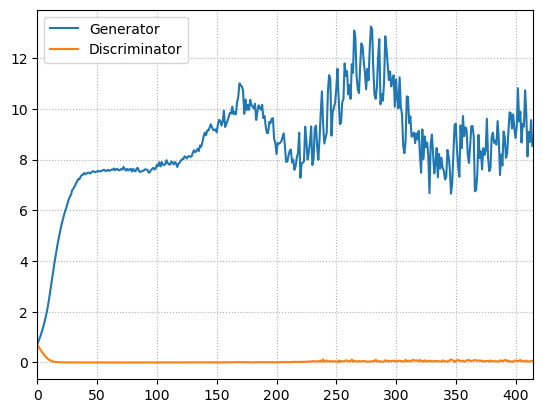

In [9]:
plt.figure()
plt.plot(losses_gen, label='Generator')
plt.plot(losses_disc, label='Discriminator')
plt.xlim([0, len(losses_gen)])
plt.grid(linestyle=':')
plt.legend()
plt.show()

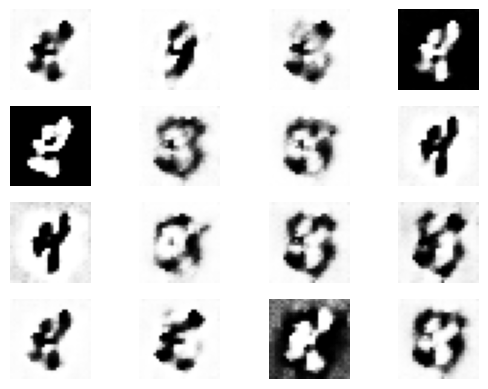

In [11]:
x_hat = gen(fixed_noise)
generated_images = x_hat.detach().cpu().numpy().reshape(-1, 28, 28)

plt.figure()

for i, img in enumerate(generated_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap='binary')
    plt.axis('off')

plt.show()

In [ ]:
# torch.save(gen.state_dict(), f'saved_models/gen_convgan.pt')
# torch.save(disc.state_dict(), f'saved_models/disc_convgan.pt')